In [1]:
import numpy as np
import os
import sys
from fractions import gcd
from numbers import Number

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from data import ArgoDataset, collate_fn
from utils import gpu, to_long,  Optimizer, StepLR

from layers import Conv1d, Res1d, Linear, LinearRes, Null
from numpy import float64, ndarray
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

from lanegcn import PredNet, get_model
import torch
from torch.utils.data import Sampler, DataLoader

import matplotlib.pyplot as plt

config, Dataset, collate_fn, net, loss, post_process, opt = get_model()
import os

import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number
import math
import torch
from torch.utils.data import Sampler, DataLoader


from utils import Logger, load_pretrain

import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12,12)




def worker_init_fn(pid):
    np_seed = int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)


dataset = Dataset(config["train_split"], config, train=True)
train_loader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    num_workers=config["workers"],
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
    drop_last=True,
)

In [32]:
trajectory_set = []
for k, data in enumerate(train_loader): 
    for i in range(len(data['trajs2'])):   # i: 0-32
        trajs2_list = []
        trajs2 = data['trajs2'][i].clone()
        for j in range(len(data['trajs2'][i])):  # j: 0-9
            trajs_raw = data['trajs2'][i][j]
            flag_sum = trajs_raw[:,2].sum()
            # print(i,j)
            if flag_sum == 50:
                orig = trajs2[j][19]
                pre = trajs2[j][15] - orig
                theta = np.pi - np.arctan2(pre[1], pre[0])
                rot = np.asarray([
                    [np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]], np.float32)
                trajs2[j][:,:2] = np.matmul(rot, (trajs2[j] - orig)[:,:2].T).T
                trajs2[j][:, 2] = 1.0

                trajectory_set.append(trajs2[j][:,:2])
                trajs2_list.append(trajs_raw.unsqueeze(1))

        data['trajs2'][i] = torch.cat(trajs2_list, dim=1).permute(1,0,2)


In [8]:
degree_threshold = 5

for traj_index, traj in enumerate(trajectory_set):
    hold_index_lst = []
    previous_azimuth = 1000

    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point 
        azimuth = (math.degrees(math.atan2(*diff_vector) + 360) % 360)

        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth

    hold_index_lst.append(traj.shape[0] - 1)

    trajectory_set[traj_index] = traj[hold_index_lst, :]


from scipy.spatial.distance import directed_hausdorff 

def hausdorff(u,v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

In [9]:
traj_count = len(trajectory_set)
D = np.zeros((traj_count, traj_count))

for i in range(traj_count):
    for j in range(i+1, traj_count):
        distance = hausdorff(trajectory_set[i], trajectory_set[j])
        D[i, j] = distance
        D[j, i] = distance


In [10]:
def plot_cluster(trajectory_set, cluster_lst):
    
    cluster_count = np.max(cluster_lst) + 1
    plt.gca().set_aspect(1)
    plt.xlim(-40,50)
    plt.ylim(-10,10)
    for traj, cluster in zip(trajectory_set, cluster_lst):
        if cluster == -1:
            plt.plot(traj[:,0], traj[:,1], c='k', linestyle='dashed')
        else:
            plt.plot(traj[:,0], traj[:,1], c=color_lst[cluster % len(color_lst)])
    plt.savefig('./cluster_mini_50.eps')
    plt.show()

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance martrix D
    m, n = D.shape

    np.fill_diagonal(D, math.inf)

    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    Mnew = np.copy(M)

    C = {}

    for t in range(tmax):
        J = np.argmin(D[:,M], axis=1)

        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa], C[kappa])], axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]

        np.sort(Mnew)

        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)

    else:
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    np.fill_diagonal(D, 0)

    return M, C

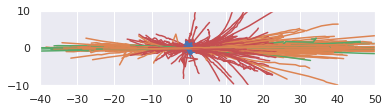

In [11]:
k = 4
method_center_lst, cluster2index_lst = kMedoids(D, k)

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown',
                  'skyblue', 'coral', 'darkorange', 'lime', 'darkkorchid', 'dimgray'])



cluster_lst = np.empty((traj_count), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst[cluster2index_lst[cluster]] = cluster

plot_cluster(trajectory_set, cluster_lst)

In [14]:
np.save('./class_50', cluster_lst)

In [35]:
print(len(cluster_lst), len(trajectory_set))

893 893


In [45]:
traj_style0, traj_style1, traj_style2, traj_style3 = [],[],[],[]
m = 0
for i in range(len(trajectory_set)):
    if cluster_lst[i] == 0:
        m += 1
        traj_style0.append(trajectory_set[i].unsqueeze(1))

    if cluster_lst[i] == 1:
        traj_style1.append(trajectory_set[i].unsqueeze(1))

    if cluster_lst[i] == 2:
        traj_style2.append(trajectory_set[i].unsqueeze(1))
    
    if cluster_lst[i] == 3:
        traj_style3.append(trajectory_set[i].unsqueeze(1))

traj_style0 = torch.cat(traj_style0, dim=1)
traj_style0 = traj_style0.permute(1, 2, 0)
traj_style1 = torch.cat(traj_style1, dim=1)
traj_style1 = traj_style1.permute(1, 2, 0)
traj_style2 = torch.cat(traj_style2, dim=1)
traj_style2 = traj_style2.permute(1, 2, 0)
traj_style3 = torch.cat(traj_style3, dim=1)
traj_style3 = traj_style3.permute(1, 2, 0)

In [51]:
torch.save(traj_style0, './style0.pth')
torch.save(traj_style1, './style1.pth')
torch.save(traj_style2, './style2.pth')
torch.save(traj_style3, './style3.pth')

In [50]:
traj_style0 = torch.load('./style0.pth')
traj_style0.size()

torch.Size([403, 2, 50])

In [21]:
from lanegcn1 import actor_gather
def get_pred_traj_rel(trajs2):
    pred_traj_rel0, actor_idcs = actor_gather(trajs2)
    pred_traj_rel = pred_traj_rel0[:,:2]
    return pred_traj_rel

pred_traj_rel = get_pred_traj_rel(data['trajs2'])

In [23]:
pred_traj_rel.size()

torch.Size([301, 2, 50])